## Import all necessary modules and set plt style paramaters

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import requests
from bidi.algorithm import get_display
import unicodedata

plt.style.use('seaborn-dark-palette')

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }

title_font = {'family': 'serif',
              'color':  'green',
              'weight': 'bold',
              'size': 12,
             }

## Calculates how many of each type are in the coordinate and returns a pandas DataFrame with the amount of each type, sorted in descending order

In [2]:
def calculate_type_amounts(current_coordinate):
    types_dictionary = {}
    
    for types in current_coordinate["types"]:
        for current_type in types:
            
            if current_type in types_dictionary:
                types_dictionary[current_type][0] += 1
                
            else:
                types_dictionary[current_type] = [1]
                
    types_df = pd.DataFrame.from_dict(types_dictionary,orient ='index',columns = ["amount"])
    types_df = types_df.sort_values(by="amount",ascending = False)
    return types_df

## Sets requested types in the coordinate dict
 - Takes the types requested by the user and sets a Dataframe with only the rows with each requested type
 - Orders the dict in the following way:
   - data_frame_dict[current_coordinate]["my_types"][current_type]:[data_frame] - Contains only location of requested type
   - Sorted by rating

In [3]:
def make_types_dictionary(data_frame_dict, my_types):
    #Remove duplicate types to decrese runtime
    my_types = list(dict.fromkeys(my_types))
    
    for coordinate in data_frame_dict:
        data_frame_dict[coordinate]["my_types"] = {}
        my_coordinate = data_frame_dict[coordinate]["locations"]

        for current_type in my_types:
            current_type_df = my_coordinate[my_coordinate["types"].apply(lambda location_types: current_type in location_types)]
            current_type_df = current_type_df.sort_values(by = "rating", ascending = False)
            data_frame_dict[coordinate]["my_types"][current_type] = current_type_df 
            
        
    return data_frame_dict

# Formulates my data in a master Data frame in the following way:
 - Takes selected types: my_types = [type1,type2...]
 - master_df = {coordinate: {locations: location_list_df, amount_of_each_type: df({type:amount...}),{my_types:{type1:df_of_type1...}}),
     
              coordinate2: ...}

In [4]:
def formulate_data(data_frame_dict, type_list):
    data_frame_dict = make_types_dictionary(data_frame_dict, type_list)
    
    for coordinate in data_frame_dict:
        types_df = calculate_type_amounts(data_frame_dict[coordinate]["locations"])
        data_frame_dict[coordinate]["amount_of_each_type"] = types_df
        
    master_df = pd.DataFrame.from_dict(data_frame_dict)
    
    return master_df

# Function for flipping hebrew names in plot index so it prints them right to left
 - Iterates on the words in the name and checks if the first letter is in hebrew 
   If it is - flips the letter order and the work order
 - Only functions properly on words that only have hebrew or english letters - 
   - If first letter is english - wont reverse hebrew
   - If first letter is hebrew - will reverse english

In [5]:
def is_hebrew(current_name):
    return 'HEBREW' in unicodedata.name(current_name.strip()[0])

def flip_hebrew_name(name):
    words = name.split(" ")
    
    for word in words:
        if is_hebrew(word):
            flipped_word = get_display(word)
            words[words.index(word)] = flipped_word
            
    words.reverse()        
    name = " ".join(words)
    return name

## Recieves an axes list a row and a column and returns an axes object

In [6]:
def get_axes(axes_list, row, column):
    current_axes = axes_list[row][column]
    return current_axes

## Recieves as axes and styles it

In [7]:
def style_ax(ax, xlab, ylab, title):
    ax.set_title(title,fontdict=title_font)
    
    ax.set_xlabel(xlab, fontdict=font)
    
    ax.set_ylabel(ylab, fontdict=font)
    
    ax.tick_params(axis="x",labelsize = 10, labelrotation=30)
    
    return ax

## Function for plotting all data
 - Makes a subplot of the following size:
     - Rows: by ammount of coordinates + 1
     - Columns: by amount of types + 1
 - Each row but the last one is compriesed of data about the given coordinate
   - First axes: Top 5 types by amount of each coordinate
   - All other axes in row - Top locations by rating of given type in coordinate
 - Last row:
   - First axes is empty
   - All other axes are the amount of a given type by coordinate - how many locations of that type are in the coordinate circle

In [8]:
def plot_data(master_df, my_types):
    
    desired_column_amount = len(master_df.loc["my_types"][0]) + 1
    
    desired_row_amount = len(master_df.columns) + 1    

    # Sets figure size to fit amount of rows and columns
    figure_length = 9 * desired_column_amount  
    figure_height = 4.5 * desired_row_amount
    data_figure, axes_list = plt.subplots(figsize=(figure_length,figure_height),dpi= 200,nrows= desired_row_amount,
                               ncols= desired_column_amount)
    
    plt.subplots_adjust(wspace = 0.4, hspace=0.8)
    data_figure.font_size= 120
    plt.xticks(rotation=30)
    
    current_row = 0
    for coordinate in master_df:
        coordinate_dict = master_df[coordinate]
        plot_coordinate(coordinate, coordinate_dict, current_row, axes_list)
        current_row = current_row + 1
        
    plot_all_coordinates_by_types(master_df, my_types, current_row, axes_list)

## Function for plotting a coordinate row
- First axes - use plot_types_amount
- Iterates on the given types and makes a plot for each

In [9]:
def plot_coordinate(coordinate, coordinate_dict, current_row, axes_list):
    current_column = 0
    
    current_ax = get_axes(axes_list, current_row, current_column)
    current_ax = plot_types_amount(coordinate_dict["amount_of_each_type"],current_ax)
    current_ax = style_ax(current_ax, "Types", "Amount", coordinate)
    
    current_column = 1
    for current_type in coordinate_dict["my_types"]:
        current_ax = get_axes(axes_list, current_row, current_column)
        current_ax = plot_type_by_rating(coordinate_dict["my_types"][current_type],current_ax)
        current_ax = style_ax(current_ax, "Names", "Rating", current_type)
        
        current_column += 1

## First coordinate axes plot
   - Make a bar plot that takes the top 5 types by amount, plot it by types


In [10]:
def plot_types_amount(types_df,current_ax):
    types_df = types_df.head(5)
    types_list = types_df.index
    amounts = types_df["amount"]
    current_ax.bar(types_list,amounts)
    
    return current_ax

## Plots type by rating
 - Make a bar plot that takes the top 5 locations of a certain type by rating, plot by location names

In [11]:
def plot_type_by_rating(type_df, current_ax):
    type_df = type_df.head(5)
    name_list = type_df["name"]
    ratings_list = type_df["rating"]
    current_ax.bar(name_list, ratings_list)
    
    return current_ax

## Function that given a type, returns the top 5 coordinates that have the most amount of that type in their circle

In [12]:
def get_all_coordinates_amount_of_type(master_df, current_type):
    coordinate_list = list(master_df.columns)
    amount_list = []
    
    for coordinate in coordinate_list:
        if not current_type in master_df[coordinate]["amount_of_each_type"].index:
            amount_list.append([0])
            
        else:
            amount_list.append(list(master_df[coordinate]["amount_of_each_type"].loc[current_type]))
            
    type_amount_out_of_all = pd.DataFrame(amount_list, coordinate_list, columns = ["amount"])
    type_amount_out_of_all = type_amount_out_of_all.sort_values(by="amount",ascending = False)
    type_amount_out_of_all = type_amount_out_of_all.head(5)
    
    return coordinate_list, type_amount_out_of_all

## Function that plots final row
 - For each type - plot top 5 coordinates that have the most of given type

In [13]:
def plot_all_coordinates_by_types(master_df, my_types, current_row, axes_list):
    current_column = 1
    for current_type in my_types:
        current_ax = get_axes(axes_list, current_row, current_column)
        coordinate_list, all_coordinates_current_type_amount = get_all_coordinates_amount_of_type(master_df, current_type)
        current_ax.bar(coordinate_list, list(all_coordinates_current_type_amount["amount"]))
        current_ax = style_ax(current_ax, "Coordinate", "Amount", current_type)
        current_column += 1
    return current_ax

## Enter coordinate list and radius in following format:
 - Coordinate list - lat,lon/lat,lon...
 - Radius = Positive number
 

** Note - can take up to a few seconds (circles with more than 20 locations take longer to run)**

In [14]:
print("Coordinate list - ")
coordinate_list = input()
print("Radius - ")
radius = input()
#coordinates for testing - 32.058895,34.805781/32.158895,34.805781
params = {"coordinate_list":coordinate_list,"radius":radius}

Coordinate list - 
32.058895,34.805781/32.158895,34.805781
Radius - 
1000


## Calls the circle searcher api with the coordinate list and radius we inputed
  - If connection fails - returns failed to connect
  - If the api returned an error code then print output
  - If request returned a valid code - set the recieved payload in "data" and run calculations on it

In [15]:
try:
    current_request = requests.get("http://192.168.1.23:5000/api/circlesearcher",params)
    data = current_request.json()
    if not current_request.status_code == 200:
        print(data)
    else:
        print("Recieved data!")
        FLIPPED_NAMES = False # Value to indicate wether the names in the list were flipped
        

except requests.ConnectionError:
    print("Failed to connect to api")

Recieved data!


## Formulates the data in a dictionary in the following way: {coordinate: data (dataframe)}

In [16]:
data_frame_dict = {}
current_data = data
for coordinate in current_data:
    my_data = current_data[coordinate]
    for location in my_data:
        if not FLIPPED_NAMES:
            name = location["name"]
            flipped_name = flip_hebrew_name(name)
            location["name"] = flipped_name
        if not "rating" in location:
            location["rating"] = 0
            location["user_ratings_total"] = 0
    my_coordinate = pd.DataFrame(data[coordinate])
    data_frame_dict[coordinate] = {"locations" : my_coordinate}
FLIPPED_NAMES = True # Solvs bug that if code is run again the location names get flipped again and are printed wrong

## Master cell - takes data, formulates it and runs all calculations - at the end plots data
 - Takes types to run specific calculations on
   - type format: type1,type2,typ3... (no space between types)
 - If more that one type selected - zoom in for data (double click)

Please enter desired types to check
food,establishment


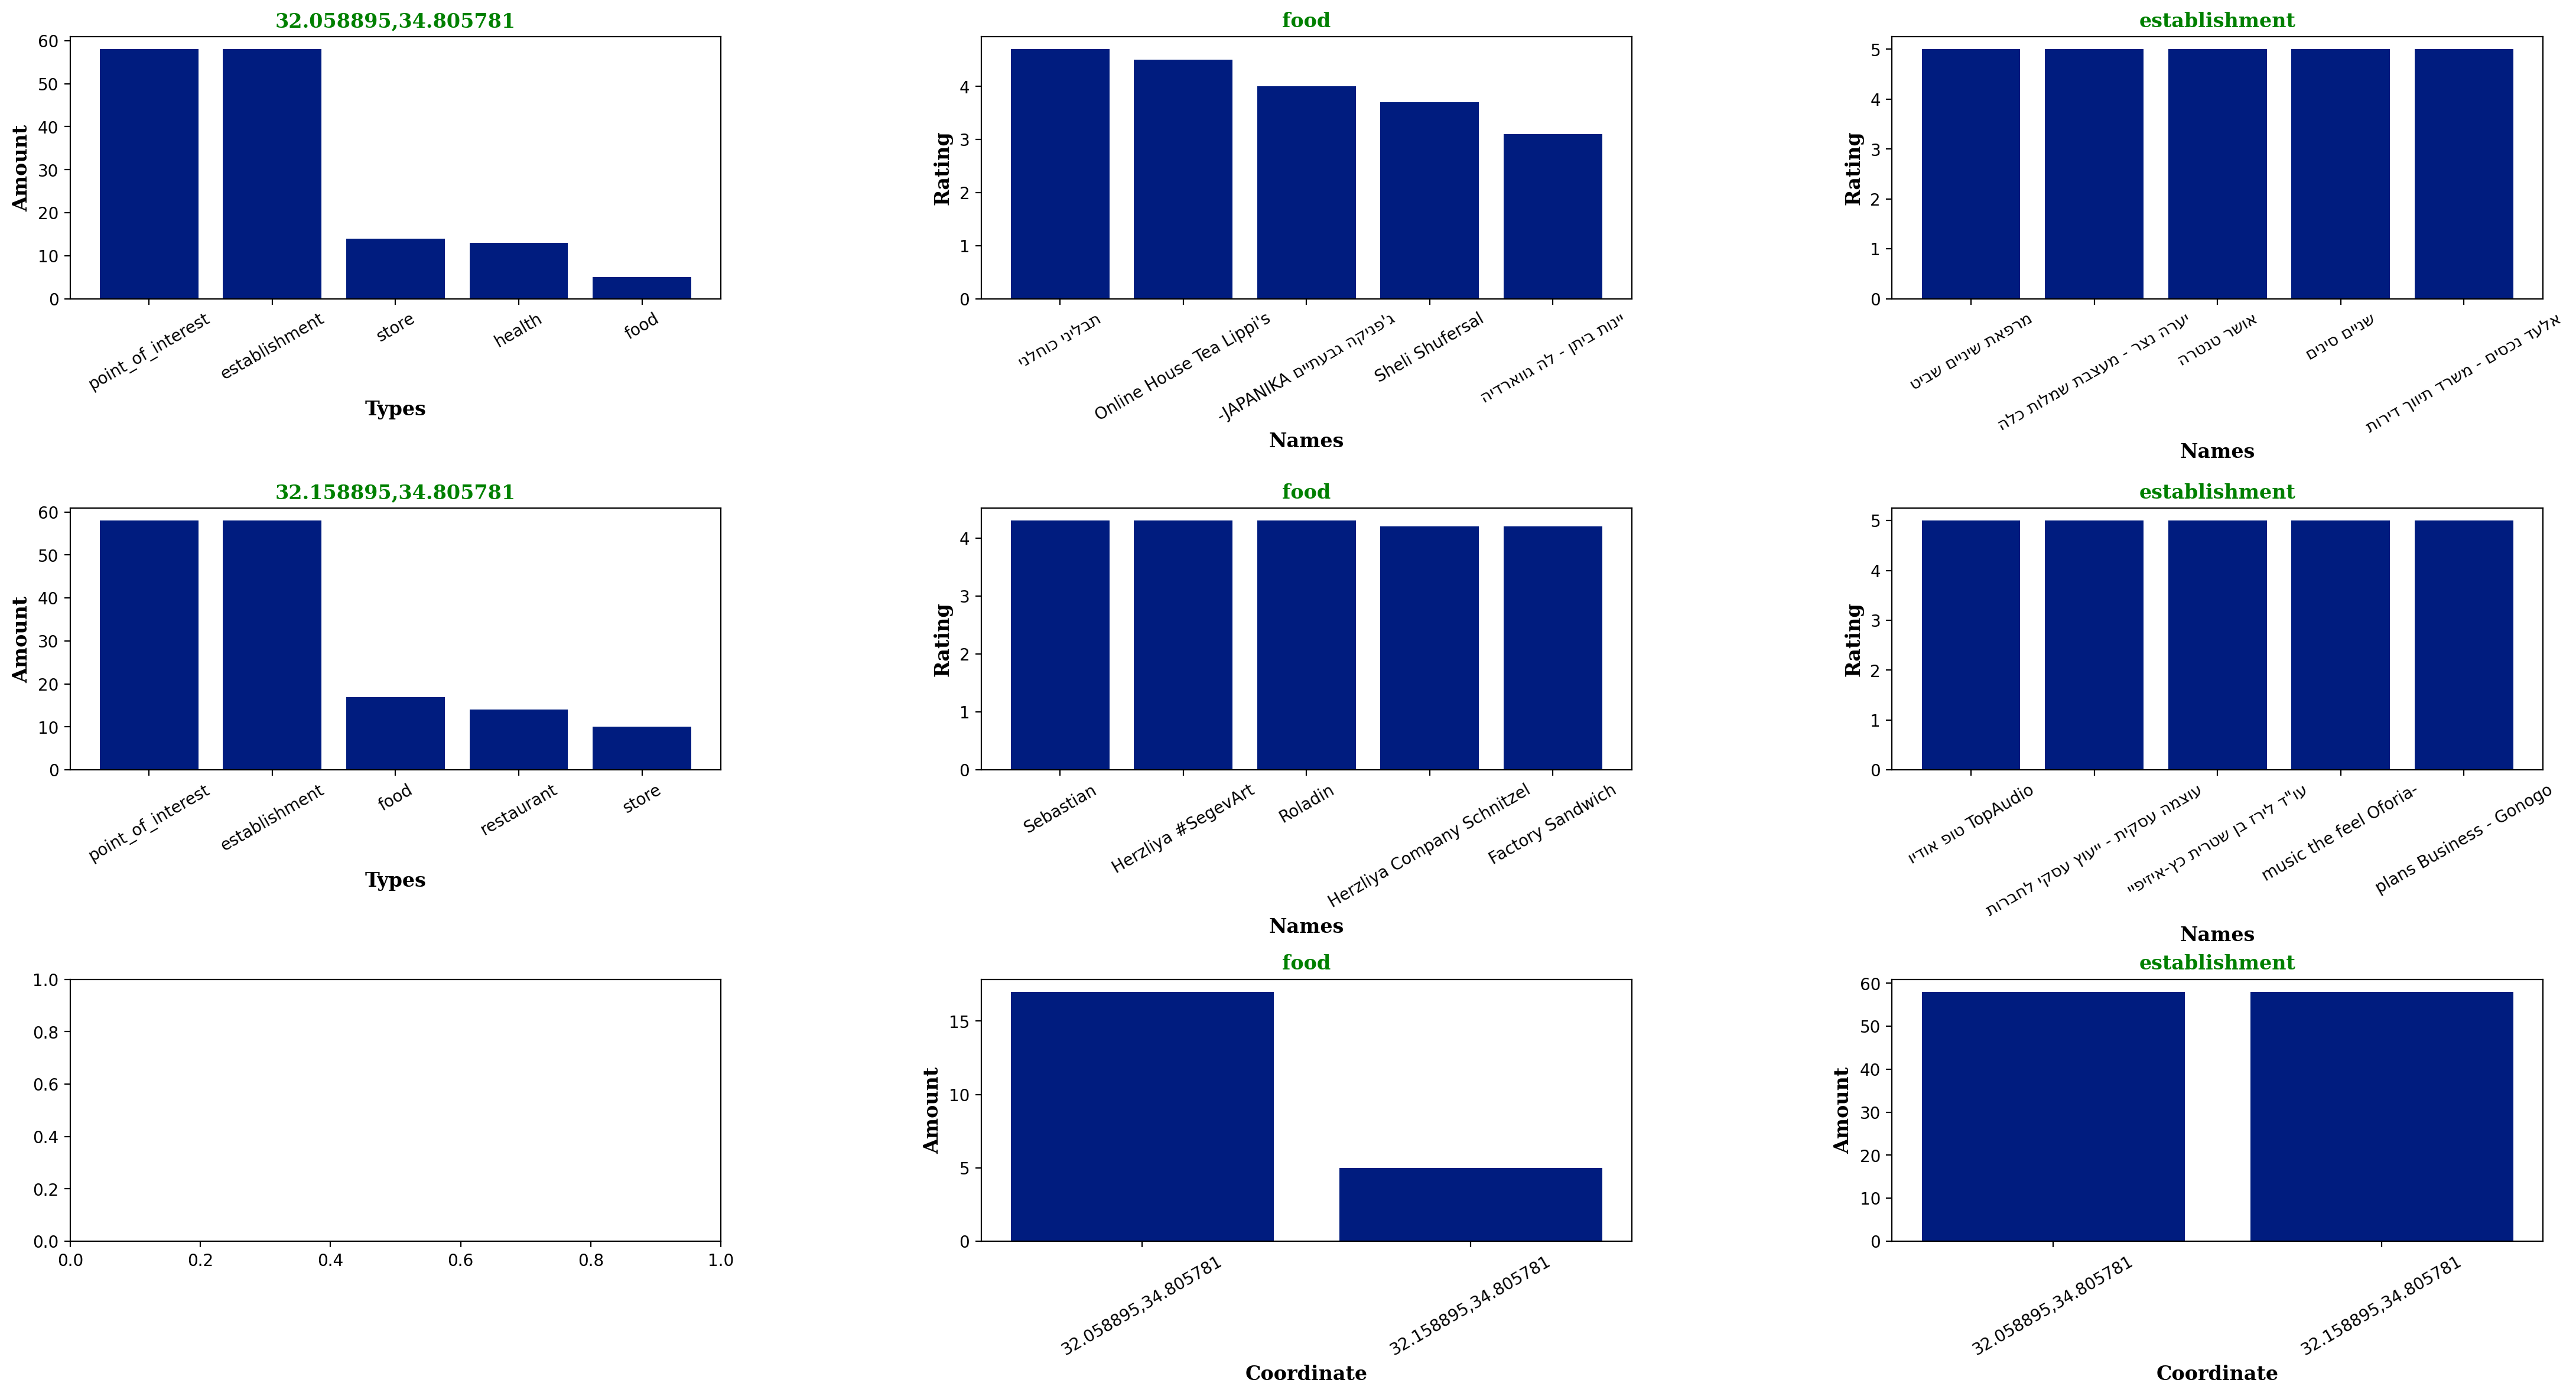

In [17]:
print("Please enter desired types to check")
my_types = input()
my_types = my_types.split(',')

master_df = formulate_data(data_frame_dict, my_types)
my_figure = plot_data(master_df, my_types)